Import libraries

In [1]:
import os 
from scipy import stats
import pandas as pd
from tqdm import tqdm
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from pprint import pprint
from scipy.stats import ttest_ind
from utils import load_pickle, pickle_data, load_json

import torch

Settings

In [3]:
data_folder = Path("/data/rbg/users/klingmin/projects/MS_processing/data")
splits_folder = Path("/data/rbg/users/klingmin/projects/MS_processing/data_splits")
frags_folder = Path("/data/rbg/users/klingmin/projects/MS_processing/data")
CFs_folder = Path("/data/rbg/users/klingmin/projects/MS_processing/CFs")
if not os.path.exists(CFs_folder): os.makedirs(CFs_folder)

MIST_folder = Path("/data/rbg/users/klingmin/projects/MS_processing/data_BM/mist")

results_list = []
for model in ["mist", "baseline_models"]:
    
    current_folder = os.path.join("/data/rbg/users/klingmin/projects/ML_MS_analysis/FP_prediction", model, "best_models")
    for expt in os.listdir(current_folder):
        # if "sieved" in expt: continue 
        if "sampled" in expt: continue 
        for checkpoint in os.listdir(os.path.join(current_folder, expt)):
            results_path = os.path.join(current_folder, expt, checkpoint, "test_results.pkl")

            assert os.path.exists(results_path), f"Checkpoint {checkpoint} does not exist"
            results_list.append(results_path)

cache_folder = "./cache"
CF_cache_folder = os.path.join(cache_folder, "CF_OOV")
CF_unique_combos_folder = os.path.join(cache_folder, "CF_unique_combos")
oov_jaccard_binned_folder = os.path.join(CF_cache_folder, "binned_results")
plots_folder = os.path.join(CF_cache_folder, "plots")

if not os.path.exists(CF_cache_folder): os.makedirs(CF_cache_folder)
if not os.path.exists(oov_jaccard_binned_folder): os.makedirs(oov_jaccard_binned_folder)
if not os.path.exists(plots_folder): os.makedirs(plots_folder)

datasets = ["massspecgym", "NIST2023"]
considered_splits = ["random", "scaffold_vanilla", "inchikey_vanilla"]

model_mapping = {"binned_": "Binned MLP",
                 "MS_": "MS Transformer",
                 "formula_": "CF Transformer",
                 "MIST_": "MIST"}

dataset_mapping = {"C": "NPLIB1",
                   "MSG": "MassSpecGym",
                   "NIST2023": "NIST2023"}

split_mapping = {"scaffold_vanilla": "Scaffold split",
                 "scaffold_vanilla_sieved": "Scaffold split",
                 "inchikey_vanilla": "InChIKey split",
                 "inchikey_vanilla_sieved": "InChIKey split",
                 "random": "Random split",
                 "random_sieved": "Random split",
                 "LS": "LS split",
                 "LS_sieved": "LS split"}

color_mapping = {"binned_": "#868686",
                 "MS_": "#A8D0DB",
                 "formula_": "#C95D63",
                 "MIST_": "#7CA982"}


Helper Functions

In [16]:
def compute_OOV_rate(frags_folder, test_ids, train_CFs):

    oov_rate_dict = {}

    for test_id in tqdm(test_ids):

        test = load_pickle(frags_folder / f"{test_id}")["peaks"]
        f_pred = [p["comment"]["f_pred"] for p in test if p["comment"]["f_pred"] != ""]
        if len(f_pred) == 0:
            oov_rate = 1.0
        else:
            oov_rate = np.mean([f not in train_CFs for f in f_pred]).item()
        oov_rate_dict[test_id.replace(".pkl", "")] = oov_rate

    return oov_rate_dict

def get_test_results(results_list, dataset, split):

    sieved_results_list = [r for r in results_list if dataset in r and split in r]

    return sieved_results_list

def get_oov_jaccard(oov_rate, test_results, sigmoid = True):

    oov_list, jaccard_list = [], []

    for k, rate in oov_rate.items():

        if k not in test_results: continue

        jaccard = jaccard_index(test_results[str(k)]["pred"], test_results[str(k)]["GT"], sigmoid = sigmoid)
        oov_list.append(rate)
        jaccard_list.append(jaccard)
    
    return oov_list, jaccard_list

def clean_test_results(test_results):

    clean_results = {}

    for k, v in test_results.items():
        if type(k) == torch.Tensor:
            k = k.item()
        clean_results[str(k)] = v 
    
    return clean_results

def to_binary(FP, threshold = 0.5):

    FP = (FP > threshold).cpu().numpy().astype(int)

    return FP

def jaccard_index(FP_pred, FP, sigmoid = True):

    FP_pred = torch.from_numpy(np.array(FP_pred))
    FP = np.array(FP).astype(int)

    # Turn to binary if 
    if sigmoid:
        FP_pred = torch.sigmoid(FP_pred)

    FP_pred = to_binary(FP_pred)

    # Intersection = bitwise AND
    intersection = np.logical_and(FP, FP_pred).sum()

    # Union = bitwise OR
    union = np.logical_or(FP, FP_pred).sum()

    # Avoid division-by-zero by adding a small epsilon
    jaccard_scores = intersection / (union + 1e-9)

    return jaccard_scores.item()

def compute_jaccard_bin_average_oov(oov_list, jaccard_list, step = 5):

    oov_list = np.array(oov_list)
    jaccard_list = np.array(jaccard_list)
    bins_list, percentile_list = [], []  
    bins = list(np.arange(0, 100, step))

    for i, p in enumerate(bins):
        p = round(p.item(), 2)
        if i == (len(bins)-1):
            bins_list.append((p, 100))
            percentile_list.append((np.percentile(jaccard_list, p).item(), np.percentile(jaccard_list, 100).item() + 1e-5))
        else:
            e = round(bins[i+1].item(), 2)
            bins_list.append((p, e))
            percentile_list.append((np.percentile(jaccard_list, p).item(), np.percentile(jaccard_list, e).item()))

    oov_bins = {i: [] for i in range(len(bins_list))}

    for i, (rate, jaccard) in enumerate(zip(oov_list, jaccard_list)):

        for j, (l, u) in enumerate(percentile_list):
            
            if jaccard >= l and jaccard < u: 
                oov_bins[j].append(rate)

    average_binned = {bins_list[k] : {"mean": np.mean(v).item(),
                                      "std": np.std(v).item()} for k,v in oov_bins.items()}

    return average_binned, oov_bins

def compute_OOV_rate_MIST(formula_folder, test_ids, train_CFs):

    oov_rate_dict = {} 

    for test_id in tqdm(test_ids):
        
        try:
            test_subformula = load_json(formula_folder / f"{test_id}.json")["output_tbl"]["formula"]
            oov_rate = np.mean([f not in train_CFs for f in test_subformula]).item()

        except Exception as e:
            print(e)
            oov_rate = 1.0 

        oov_rate_dict[test_id] = oov_rate
    
    return oov_rate_dict

`` Look at the percentage of OOV rate in the dataset ``

In [21]:
datasets = ["massspecgym", "nist2023"]
considered_splits = ["random", "scaffold_vanilla", "inchikey_vanilla", "LS",
                     "random_sieved", "scaffold_vanilla_sieved", "inchikey_vanilla_sieved", "LS_sieved"]
oov_results = [] 

for dataset in datasets: 

    for s in considered_splits:

        CFs = CFs_folder / dataset/ f"{s}_split"
        train_path, test_path = CFs / "train_CFs.pkl", CFs / "test_CFs.pkl"
        if not os.path.exists(train_path) or not os.path.exists(test_path): continue 
        train_CFs = load_pickle(train_path)
        test_CFs = load_pickle(test_path)

        oov_test_CFs = test_CFs - train_CFs
        oov_test_CFs_rate = round(len(oov_test_CFs) / len(test_CFs) * 100, 3)
        oov_results.append((dataset, s, len(train_CFs), len(test_CFs), oov_test_CFs_rate))

oov_results = pd.DataFrame(oov_results, columns=["dataset", "split", "train_CFs", "test_CFs", "oov_test_CFs_rate"])
oov_results

,dataset,split,train_CFs,test_CFs,oov_test_CFs_rate
0,massspecgym,random,74110,37113,13.742
1,massspecgym,scaffold_vanilla,66014,32388,31.895
2,massspecgym,inchikey_vanilla,69233,29404,27.697
3,massspecgym,LS,63091,44310,39.255
4,massspecgym,random_sieved,36630,16560,18.967
5,massspecgym,scaffold_vanilla_sieved,32893,14976,36.084
6,massspecgym,inchikey_vanilla_sieved,34527,13837,32.738
7,massspecgym,LS_sieved,25287,28689,54.345
8,nist2023,random,232608,140649,7.599
9,nist2023,scaffold_vanilla,186438,90234,36.188


In [22]:
datasets = ["massspecgym", "nist2023"]
considered_splits = ["random", "scaffold_vanilla", "inchikey_vanilla",
                     "random_sieved", "scaffold_vanilla_sieved", "inchikey_vanilla_sieved", "LS_sieved"]
oov_results_mist = [] 

for dataset in datasets: 

    for s in considered_splits:

        CFs = CFs_folder / dataset/ f"{s}_split"
        train_path, test_path = CFs / "train_MIST_CFs.pkl", CFs / "test_MIST_CFs.pkl"
        if not os.path.exists(train_path) or not os.path.exists(test_path): continue 
        train_CFs = load_pickle(train_path)
        test_CFs = load_pickle(test_path)

        oov_test_CFs = test_CFs - train_CFs
        oov_test_CFs_rate = round(len(oov_test_CFs) / len(test_CFs) * 100, 3)
        oov_results_mist.append((dataset, s, len(train_CFs), len(test_CFs), oov_test_CFs_rate))

oov_results_mist = pd.DataFrame(oov_results_mist, columns=["dataset", "split", "train_CFs", "test_CFs", "oov_test_CFs_rate"])
oov_results_mist

,dataset,split,train_CFs,test_CFs,oov_test_CFs_rate
0,massspecgym,random,82757,40713,15.096
1,massspecgym,scaffold_vanilla,73897,34367,33.980
2,massspecgym,inchikey_vanilla,77219,31556,30.536
3,massspecgym,random_sieved,43284,18591,21.301
4,massspecgym,scaffold_vanilla_sieved,38912,16695,39.820
5,massspecgym,inchikey_vanilla_sieved,40842,15313,35.819
6,massspecgym,LS_sieved,28626,34165,58.800
7,nist2023,random,119311,71951,8.275
8,nist2023,scaffold_vanilla,98694,44427,36.635
9,nist2023,inchikey_vanilla,106679,43115,30.426


`` Compute the OOV rate at the record level``

In [24]:
datasets = ["nist2023"]
considered_splits = ["scaffold_vanilla", "inchikey_vanilla", "random", "LS"]

for dataset in datasets: 

    for s in considered_splits:

        output_path = os.path.join(CF_cache_folder, f"{dataset}_{s}.pkl")

        if not os.path.exists(output_path):

            CFs = CFs_folder / dataset/ f"{s}_split"
            train_path = CFs / "train_CFs.pkl"
            if not os.path.exists(train_path): continue
            train_CFs = load_pickle(train_path)

            split_path = splits_folder / dataset / "splits" / f"{s}.json"
            test_ids = load_json(split_path)["test"]
            frags = frags_folder / dataset / "frags_preds"

            oov_rate = compute_OOV_rate(frags, test_ids, train_CFs)
            pickle_data(oov_rate, output_path)

        # Do a version for MIST too 
        MIST_output_path = os.path.join(CF_cache_folder, f"{dataset}_MIST_{s}.pkl")
        if not os.path.exists(MIST_output_path):

            CFs = CFs_folder / dataset / f"{s}_split"
            train_path = CFs / "train_MIST_CFs.pkl"
            train_CFs = load_pickle(train_path)

            formula_folder = MIST_folder / dataset / "subformulae" / "default_subformulae"
            split_path = MIST_folder / dataset / "splits" / f"{s}.tsv"
            splits = pd.read_csv(split_path).values
            test_ids = [r[0].split("\t")[0] for r in splits if r[0].split("\t")[-1] == "test"]

            oov_rate = compute_OOV_rate_MIST(formula_folder, test_ids, train_CFs)
            pickle_data(oov_rate, MIST_output_path)

`` Look at how the statistics of the data change ``

In [25]:
for dataset in ["massspecgym", "nist2023"]:

    current_data_folder = os.path.join(data_folder, dataset, "frags_preds")
    all_mols_combo_path = os.path.join(CF_unique_combos_folder, f"{dataset}_all_mols_combo.pkl")
    all_CFs_combo_path = os.path.join(CF_unique_combos_folder, f"{dataset}_all_CFs_combo.pkl")
    combo_mol_matching_path = os.path.join(CF_unique_combos_folder, f"{dataset}_combo_mol_matching.pkl")

    all_mols_combo = load_pickle(all_mols_combo_path)
    all_CFs_combo = load_pickle(all_CFs_combo_path)
    combo_mol_matching = load_pickle(combo_mol_matching_path)

    count_more_1, count_more_1_non_unique = 0, 0 

    for k, v in combo_mol_matching.items():
        if len(v) > 1:
            count_more_1 += 1 
            if len(set(v)) > 1: 
                count_more_1_non_unique += 1 
    
    print(len(os.listdir(current_data_folder)), len(all_CFs_combo), len(all_mols_combo))
    percent_more_than_1 = round(count_more_1 / len(all_CFs_combo) * 100, 3)
    percent_more_than_1_non_unique = round(count_more_1_non_unique / count_more_1 * 100, 3)
    print(percent_more_than_1, percent_more_than_1_non_unique)

KeyboardInterrupt: 

`` Look at the distribution of scores across different oov rate bins ``

In [19]:
datasets = ["canopus", "massspecgym", "nist2023"]
considered_splits = ["inchikey_vanilla", "scaffold_vanilla", "random", "LS"]
step = 10
scores = {}

for dataset in tqdm(datasets): 

    for s in tqdm(considered_splits):

        all_results = get_test_results(results_list, dataset, s)

        for test_results_path in tqdm(all_results): 
            
            expt = test_results_path.split("/")[-2]
            if "MIST_" not in expt: continue 

            output_path_avg = os.path.join(oov_jaccard_binned_folder, f"{expt}_avg_step_{step}_2.pkl")
            output_path_raw = os.path.join(oov_jaccard_binned_folder, f"{expt}_raw_step_{step}_2.pkl")

            if not os.path.exists(output_path_avg):

                print(f"Processing {expt} now")

                # if "MIST_" in expt:
                #     oov_rate_path = os.path.join(CF_cache_folder, f"{dataset}_MIST_{s}.pkl")
                # else:
                #     oov_rate_path = os.path.join(CF_cache_folder, f"{dataset}_{s}.pkl")

                oov_rate_path = os.path.join(CF_cache_folder, f"{dataset}_{s}.pkl")
                oov_rate = load_pickle(oov_rate_path)

                test_results = load_pickle(test_results_path)
                test_results = clean_test_results(test_results)

                sigmoid = True
                if "MIST_" in expt: sigmoid = False 
                oov_list, jaccard_list = get_oov_jaccard(oov_rate, test_results, sigmoid = sigmoid)
                avg_jaccard_oov_bins, raw_jaccard_oov_bins = compute_jaccard_bin_average_oov(oov_list, jaccard_list, step = step)

                pickle_data(avg_jaccard_oov_bins, output_path_avg)
                pickle_data(raw_jaccard_oov_bins, output_path_raw)

  0%|          | 0/3 [00:00<?, ?it/s]


Processing C_MIST_4096_inchikey_vanilla now



100%|██████████| 4/4 [00:03<00:00,  1.04it/s]



Processing C_MIST_meta_4096_scaffold_vanilla now



100%|██████████| 4/4 [00:03<00:00,  1.11it/s]



Processing C_MIST_4096_random now



100%|██████████| 4/4 [00:03<00:00,  1.08it/s]



Processing C_MIST_meta_4096_LS now



 33%|███▎      | 1/3 [00:18<00:37, 18.76s/it]


Processing MSG_MIST_meta_4096_inchikey_vanilla now


Processing MSG_MIST_sieved_4096_inchikey_vanilla_sieved now



100%|██████████| 8/8 [00:26<00:00,  3.26s/it]



Processing MSG_MIST_meta_4096_scaffold_vanilla now


Processing MSG_MIST_sieved_4096_scaffold_vanilla_sieved now



100%|██████████| 8/8 [00:27<00:00,  3.39s/it]



Processing MSG_MIST_4096_random now


Processing MSG_MIST_sieved_4096_random_sieved now



100%|██████████| 8/8 [00:26<00:00,  3.30s/it]



Processing MSG_MIST_meta_4096_LS now


Processing MSG_MIST_meta_4096_LS_sieved now



 67%|██████▋   | 2/3 [02:17<01:17, 77.79s/it]


Processing NIST2023_MIST_sieved_4096_inchikey_vanilla_sieved now


Processing NIST2023_MIST_4096_inchikey_vanilla now



100%|██████████| 8/8 [01:16<00:00,  9.58s/it]



Processing NIST2023_MIST_sieved_4096_scaffold_vanilla_sieved now


Processing NIST2023_MIST_meta_4096_scaffold_vanilla now



100%|██████████| 8/8 [01:27<00:00, 10.97s/it]



Processing NIST2023_MIST_sieved_4096_random_sieved now


Processing NIST2023_MIST_meta_4096_random now



100%|██████████| 8/8 [01:20<00:00, 10.09s/it]



Processing NIST2023_MIST_meta_4096_LS_sieved now


Processing NIST2023_MIST_meta_4096_LS now



100%|██████████| 3/3 [06:59<00:00, 139.86s/it]


  0%|          | 0/2 [00:00<?, ?it/s]

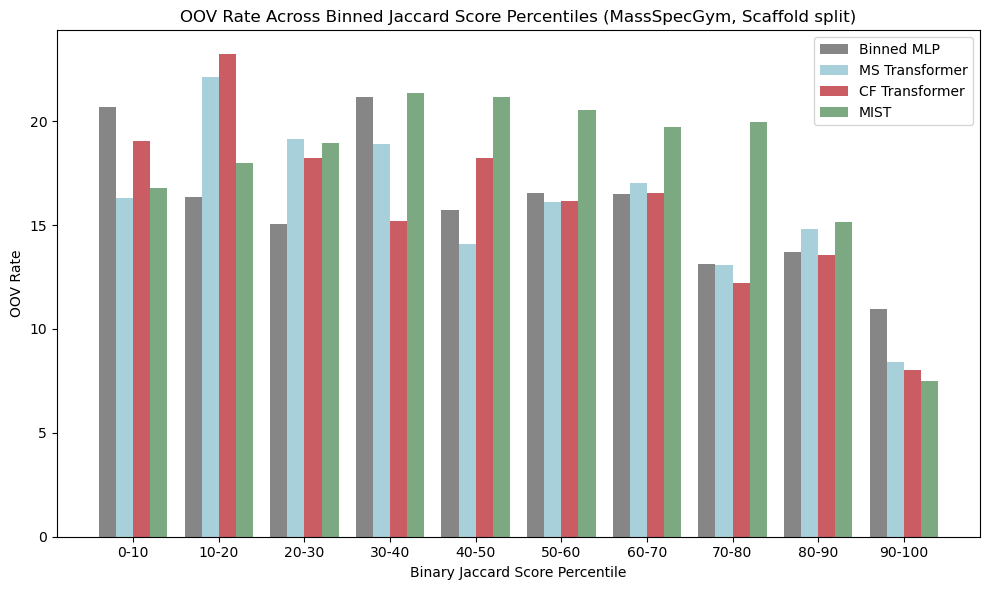

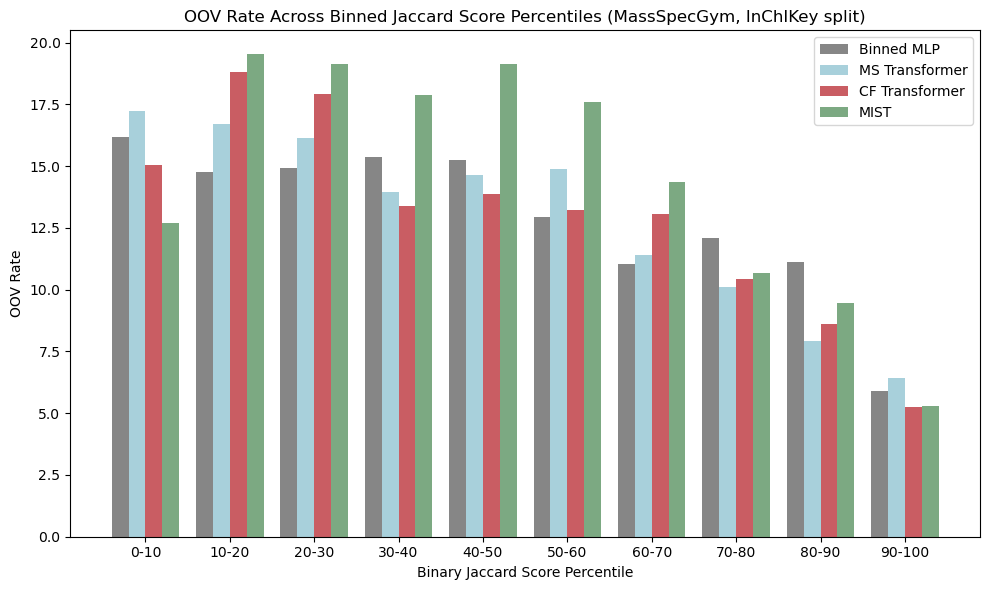

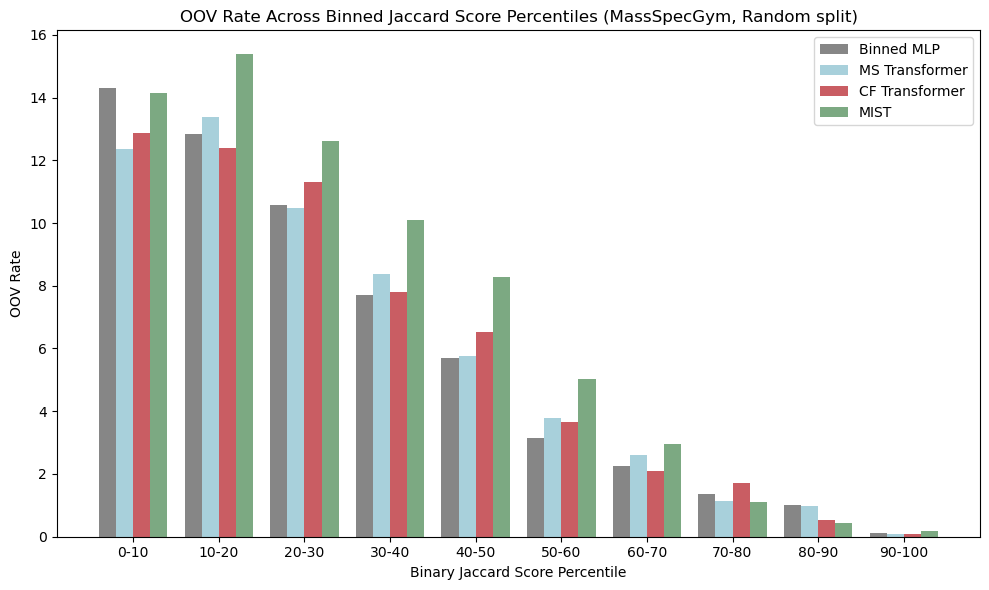

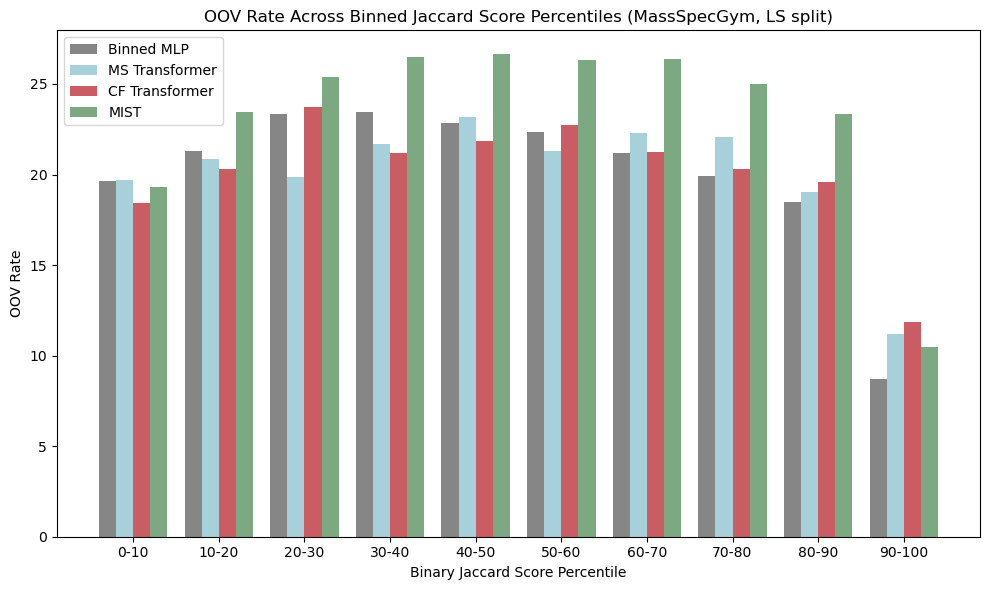

 50%|█████     | 1/2 [00:02<00:02,  2.50s/it]

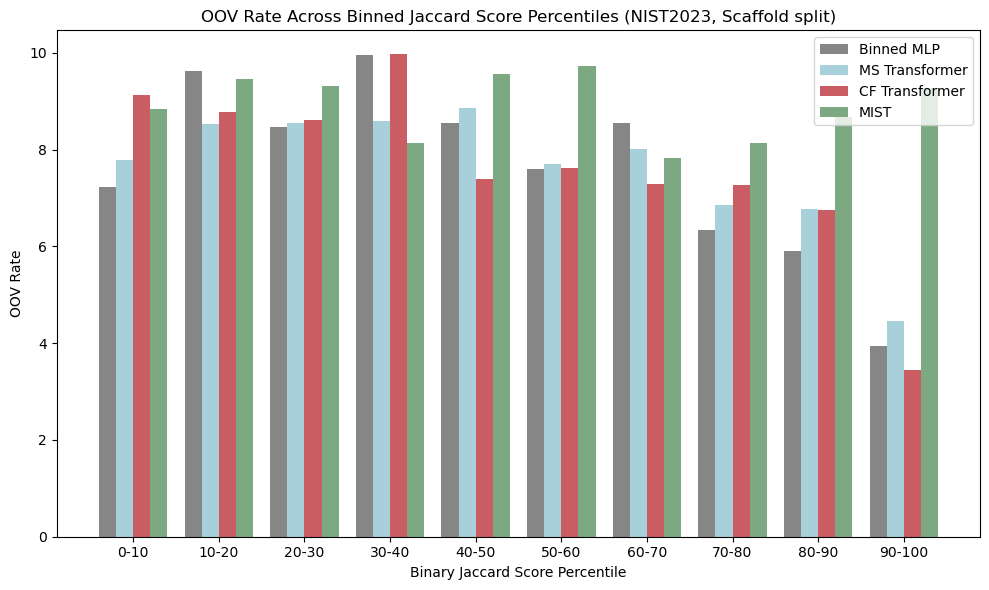

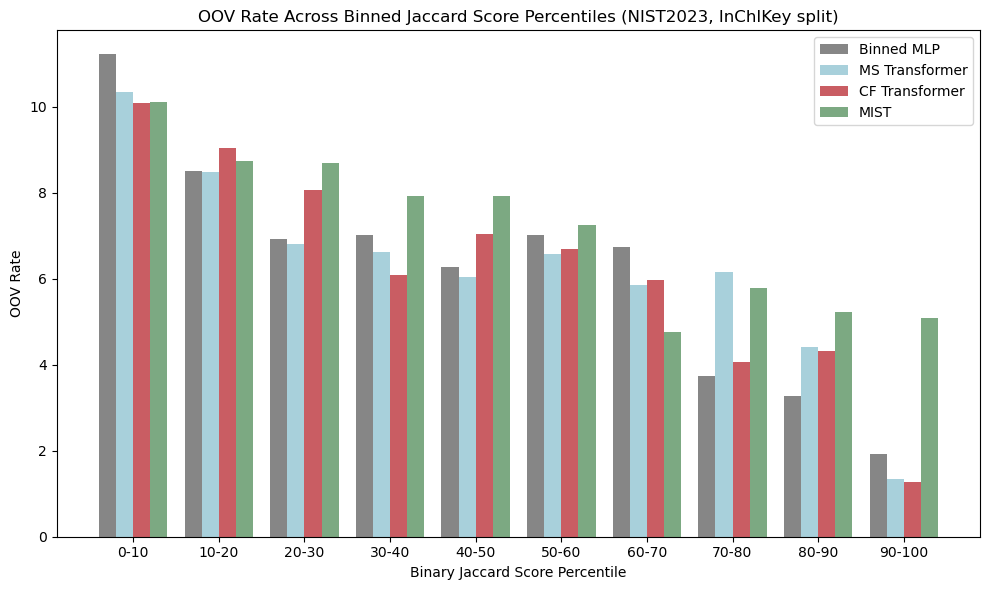

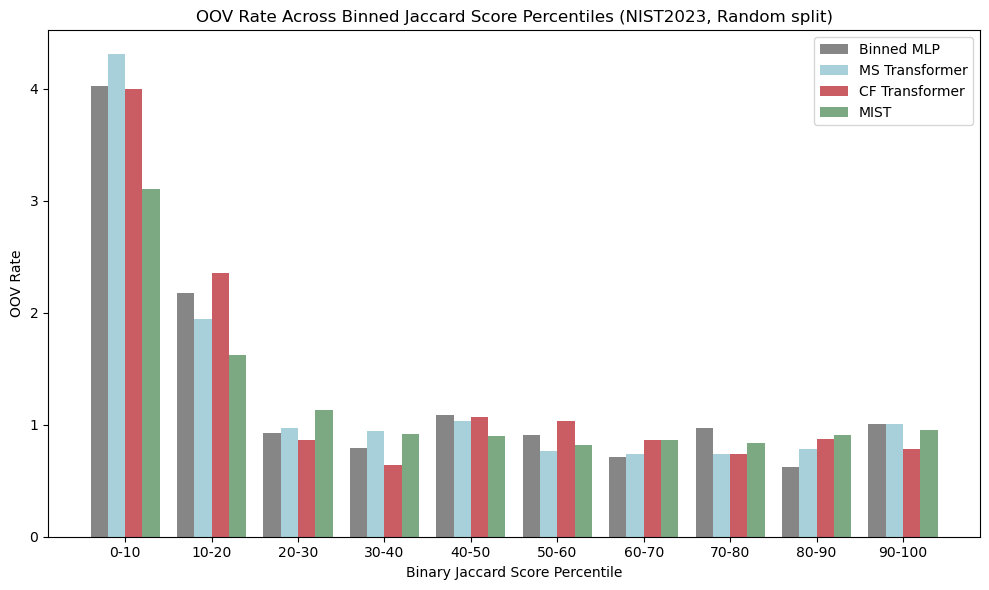

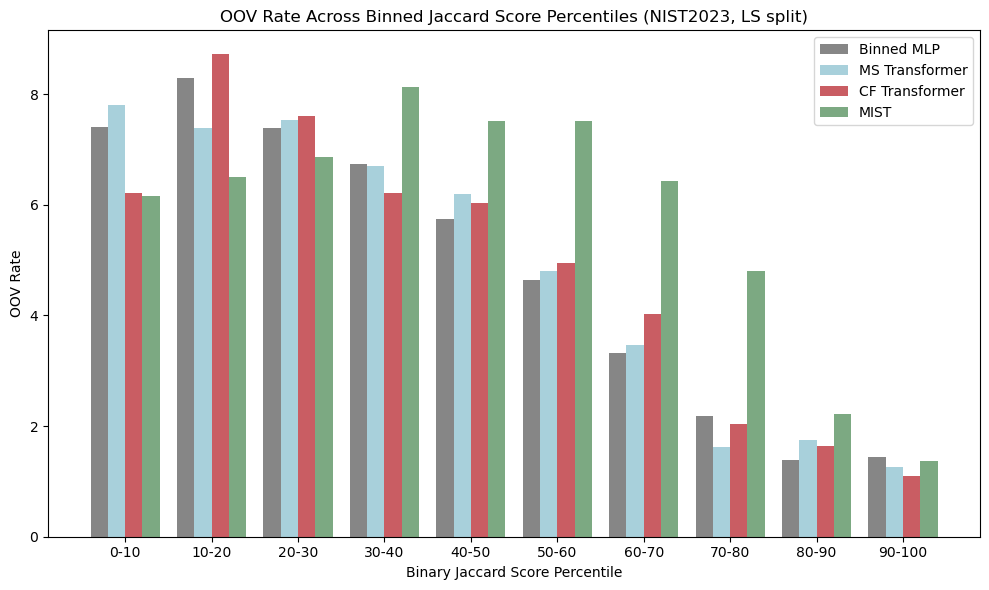

100%|██████████| 2/2 [00:04<00:00,  2.10s/it]


In [4]:
datasets = ["MSG", "NIST2023"]
considered_splits = ["scaffold_vanilla_sieved", "inchikey_vanilla_sieved", "random_sieved", "LS_sieved"]
models = ["binned_", "MS_", "formula_", "MIST_"]
step = 10

for dataset in tqdm(datasets): 

    scores = {}

    for s in tqdm(considered_splits):

        for model in models:
            
            path = [os.path.join(oov_jaccard_binned_folder, f) \
                    for f in os.listdir(oov_jaccard_binned_folder) \
                    if dataset in f and s in f and model in f \
                    and f"step_{step}" in f \
                    and "avg" in f]
            
            assert len(path) == 1 
            path = path[0]

            oov_rate_binned = load_pickle(path)
            for k, v in oov_rate_binned.items():
                if k not in scores: scores[k] = {} 
                scores[k][model] = v 

        # Plotting grouped bars
        fig, ax = plt.subplots(figsize=(10, 6))

        bar_width = 0.20
        labels = [f"{l[0]}-{l[1]}" for l in scores.keys()]
        x = range(len(scores))

        # Loop over columns (models/splits)
        for i, model in enumerate(models):
            ax.bar([pos + i * bar_width for pos in x], [v[model]["mean"] * 100 for v in scores.values()],  
                width=bar_width, label = model_mapping[model], color = color_mapping[model])

        # Formatting
        ax.set_xticks([pos + bar_width + (bar_width * 0.5) for pos in x])
        ax.set_xticklabels(labels)
        ax.set_xlabel("Binary Jaccard Score Percentile")
        ax.set_ylabel("OOV Rate")
        ax.set_title(f"OOV Rate Across Binned Jaccard Score Percentiles ({dataset_mapping[dataset]}, {split_mapping[s]})")
        ax.legend()
        
        plt.tight_layout()
        plt.savefig(os.path.join(plots_folder, f"oov_rate_{dataset}_{s}_{step}.png"), bbox_inches='tight')

        plt.show()

Compute the one-sided t test

In [49]:
datasets = ["C", "MSG", "NIST2023"]
considered_splits = ["inchikey_vanilla", "scaffold_vanilla", "random", "LS"]
models = ["binned_", "MS_", "formula_", "MIST_"]
step = 10
scores = [] 

for dataset in tqdm(datasets): 

    for s in tqdm(considered_splits):

        for model in models:
            
            path = [os.path.join(oov_jaccard_binned_folder, f) \
                    for f in os.listdir(oov_jaccard_binned_folder) \
                    if dataset in f and s in f and model in f \
                    and f"step_{step}" in f \
                    and "raw" in f and "sieved" not in f]
            
            if model == "MIST_":
                path = [p for p in path if "_2.pkl" in p]

            if len(path) != 1: 
                print(dataset, s, model)
                print(path)

            assert len(path) == 1 
            path = path[0]

            oov_rate_binned = load_pickle(path)
            binned_keys = list(oov_rate_binned.keys())

            high_percentile = oov_rate_binned[binned_keys[-1]]
            low_percentile = oov_rate_binned[binned_keys[0]]

            t_stat, p_two_sided = stats.ttest_ind(high_percentile, low_percentile, equal_var=False) # to test that high percentile has a lower oov rate than low percentile
            
            if t_stat < 0:
                p_one_sided = p_two_sided / 2
            else:
                p_one_sided = 1 - (p_two_sided / 2)
        
            scores.append([dataset_mapping[dataset], model_mapping[model], split_mapping[s], 
                           round(np.mean(low_percentile).item() * 100,2), round(np.mean(high_percentile).item() * 100,2),
                           p_one_sided, p_one_sided <= 5/100])



100%|██████████| 3/3 [00:01<00:00,  2.96it/s]


In [52]:
splits = ["Scaffold split", "LS split"]
scores_df = pd.DataFrame(scores, columns=["dataset", "model", "split", "OOV Rate (low percentile)", "OOV Rate (high percentile)", "one-sided t test p value", "significant"])
scores_df.query("dataset == 'NPLIB1'").query("split in @splits")
# scores_df

,dataset,model,split,OOV Rate (low percentile),OOV Rate (high percentile),one-sided t test p value,significant
4,NPLIB1,Binned MLP,Scaffold split,9.00,1.64,6.363678e-11,True
5,NPLIB1,MS Transformer,Scaffold split,10.59,2.55,2.385675e-09,True
6,NPLIB1,CF Transformer,Scaffold split,9.52,2.45,5.340849e-08,True
7,NPLIB1,MIST,Scaffold split,9.05,3.81,2.866594e-04,True
12,NPLIB1,Binned MLP,LS split,13.31,4.60,2.917891e-12,True
13,NPLIB1,MS Transformer,LS split,14.17,4.43,4.138935e-14,True
14,NPLIB1,CF Transformer,LS split,14.03,3.76,7.023521e-16,True
15,NPLIB1,MIST,LS split,7.15,8.52,8.649853e-01,False
